In [155]:
import matplotlib.pyplot as plt
import bagpy
import pandas as pd
import numpy as np

In [156]:
bag = bagpy.bagreader('/home/ziad/ever_comp/src/autonomx_state_estimator/rosbags/ekf_ms/ekf_rad_error_circular_2024-05-07-20-26-13.bag')
bag.topic_table

[INFO]  Successfully created the data folder /home/ziad/ever_comp/src/autonomx_state_estimator/rosbags/ekf_ms/ekf_rad_error_circular_2024-05-07-20-26-13.


,Topics,Types,Message Count,Frequency
0,/Imu,sensor_msgs/Imu,10888,99.624807
1,/SteeringAngle,std_msgs/Float64,11342,100.004864
2,/clock,rosgraph_msgs/Clock,10888,99.582231
3,/cmd_vel,std_msgs/Float64,11342,100.004864
4,/current_heading,std_msgs/Float64,8666,98.520283
5,/current_linear_velocity,geometry_msgs/Vector3,8666,98.605981
6,/current_position,geometry_msgs/Vector3,8666,98.677897
7,/ground_truth,nav_msgs/Odometry,8666,98.448596
8,/noisy_readings,nav_msgs/Odometry,8666,98.330887
9,/odom,nav_msgs/Odometry,10888,99.657947


In [157]:
# extract topics of interest
ground_truth_topic_data = pd.read_csv(bag.message_by_topic('/ground_truth'))
noisy_data_topic_data = pd.read_csv(bag.message_by_topic('/noisy_readings'))
heading_estimations_topic_data = pd.read_csv(bag.message_by_topic('/current_heading'))
velocity_estimations_topic_data = pd.read_csv(bag.message_by_topic('/current_linear_velocity'))
position_estimation_topic_data = pd.read_csv(bag.message_by_topic('/current_position'))

# filtered_heading_topic_data = pd.read_csv(bag.message_by_topic('/filtered_heading'))

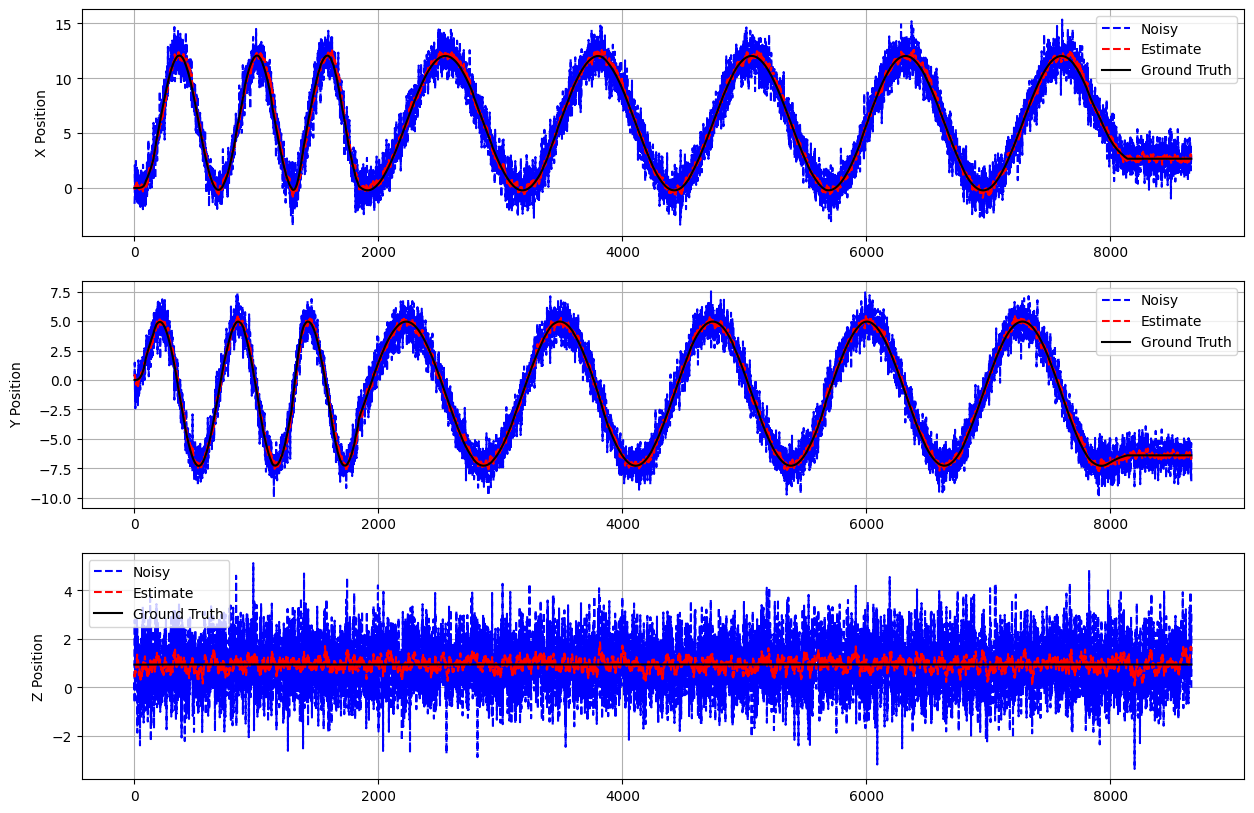

In [158]:
'''
    Plotting Ground Truth Velocity Compared to Estimated Velocities
'''

# extract the data i need as pd.sereis and store them in a list
ground_truth_position = [ground_truth_topic_data['pose.pose.position.x'], ground_truth_topic_data['pose.pose.position.y'], ground_truth_topic_data['pose.pose.position.z']]
noisy_position = [noisy_data_topic_data['pose.pose.position.x'], noisy_data_topic_data['pose.pose.position.y'], noisy_data_topic_data['pose.pose.position.z']]
estimated_position = [position_estimation_topic_data['x'], position_estimation_topic_data['y'], position_estimation_topic_data['z']]

fig1, axes1 = plt.subplots(3, 1, figsize=(15, 10))  # Create 3 rows, 1 column subplot
for i, ax in enumerate(axes1):
    ax.plot(range(len(noisy_position[i])), noisy_position[i], label='Noisy', color='blue', linestyle = '--')
    ax.plot(range(len(estimated_position[i])), estimated_position[i], label='Estimate', color='red', linestyle = '--')
    ax.plot(range(len(ground_truth_position[i])), ground_truth_position[i], label='Ground Truth', color='black')
    axis = 'X' if i==0 else ('Y' if i==1 else 'Z')
    ax.set_ylabel(f'{axis} Position')
    ax.legend()
    ax.grid()

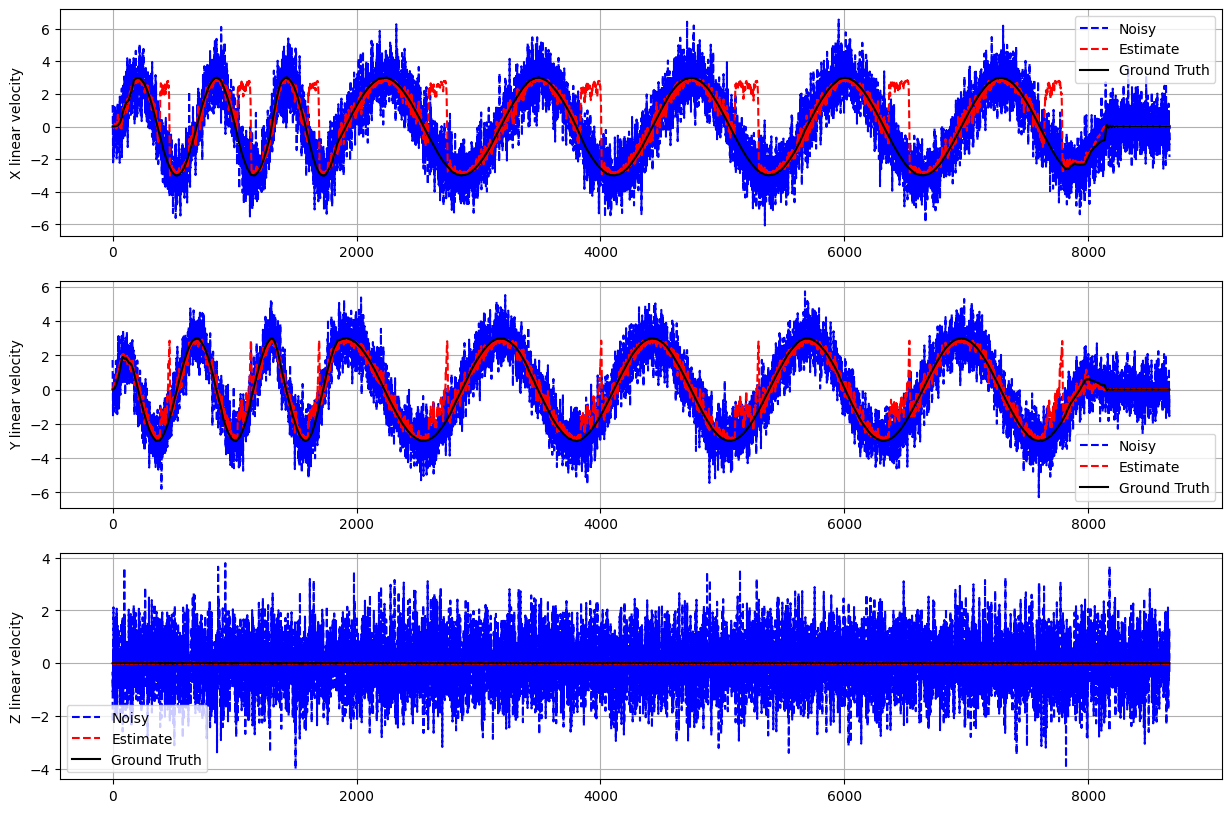

In [159]:
'''
    Plotting Ground Truth Velocity Compared to Estimated Velocities
'''

# extract the data i need as pd.sereis and store them in a list
ground_truth_velocity = [ground_truth_topic_data['twist.twist.linear.x'], ground_truth_topic_data['twist.twist.linear.y'], ground_truth_topic_data['twist.twist.linear.z']]
noisy_velocity = [noisy_data_topic_data['twist.twist.linear.x'], noisy_data_topic_data['twist.twist.linear.y'], noisy_data_topic_data['twist.twist.linear.z']]
estimated_velocity = [velocity_estimations_topic_data['x'], velocity_estimations_topic_data['y'], velocity_estimations_topic_data['z']]

fig1, axes1 = plt.subplots(3, 1, figsize=(15, 10))  # Create 3 rows, 1 column subplot
for i, ax in enumerate(axes1):
    ax.plot(range(len(noisy_velocity[i])), noisy_velocity[i], label='Noisy', color='blue', linestyle = '--')
    ax.plot(range(len(estimated_velocity[i])), estimated_velocity[i], label='Estimate', color='red', linestyle = '--')
    ax.plot(range(len(ground_truth_velocity[i])), ground_truth_velocity[i], label='Ground Truth', color='black')
    axis = 'X' if i==0 else ('Y' if i==1 else 'Z')
    ax.set_ylabel(f'{axis} linear velocity')
    ax.legend()
    ax.grid()

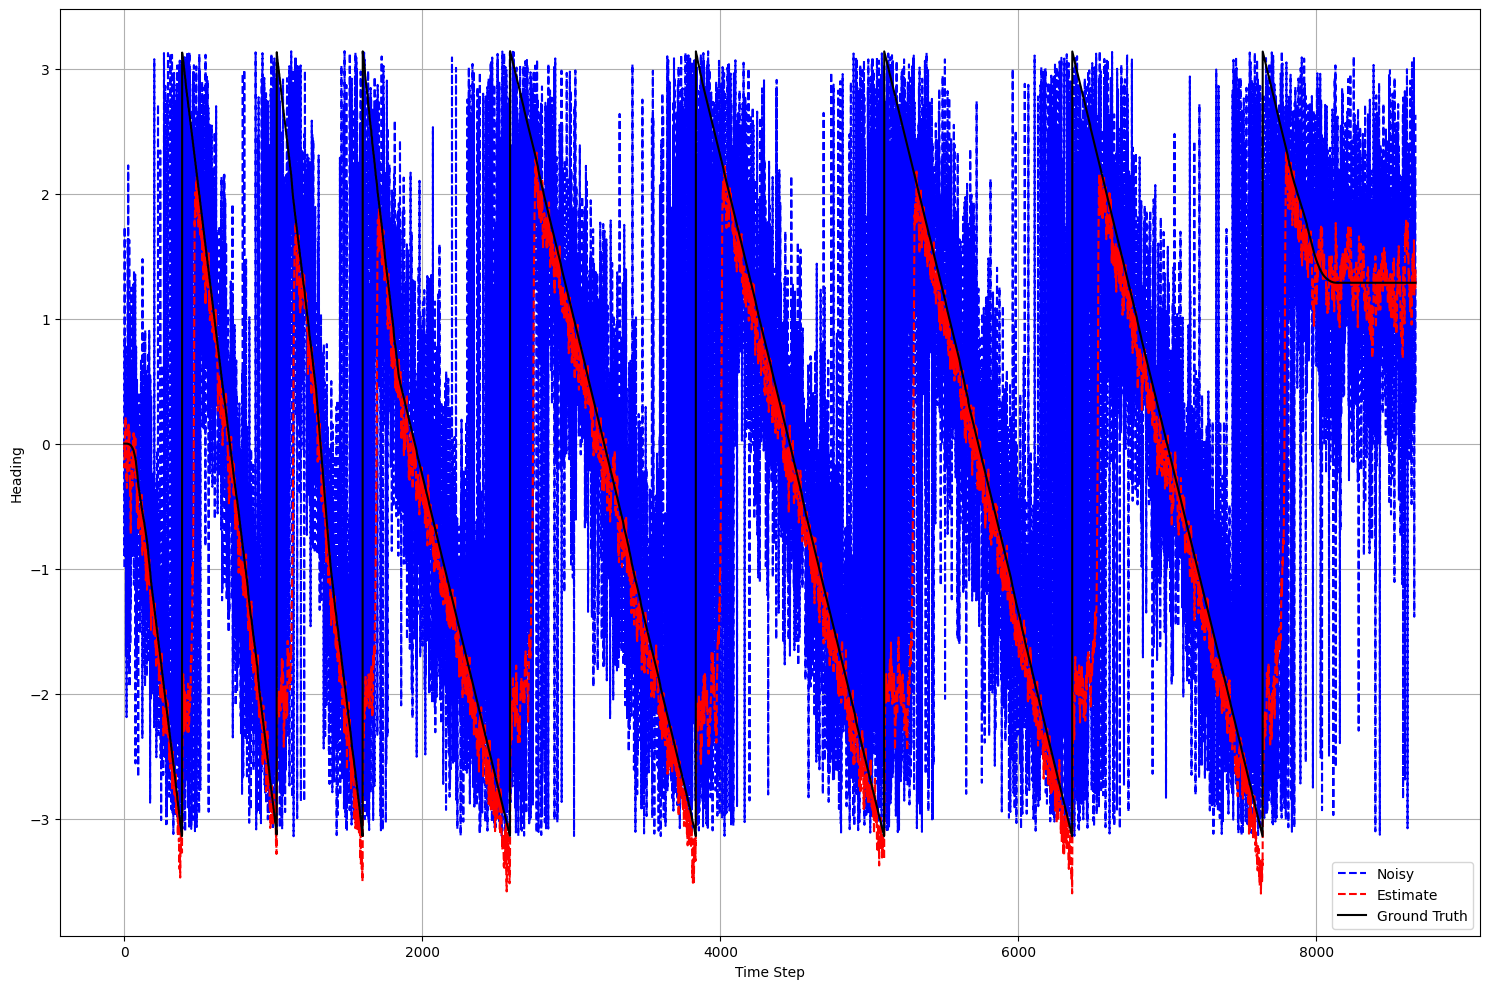

8666
8666


In [160]:
'''
    Plotting the ground truth heading compared to the estimated heading
'''
from tf.transformations import euler_from_quaternion

ground_truth_orientation = [ground_truth_topic_data['pose.pose.orientation.x'], ground_truth_topic_data['pose.pose.orientation.y'],ground_truth_topic_data['pose.pose.orientation.z'], ground_truth_topic_data['pose.pose.orientation.w']]
noisy_orientation = [noisy_data_topic_data['pose.pose.orientation.x'], noisy_data_topic_data['pose.pose.orientation.y'],noisy_data_topic_data['pose.pose.orientation.z'], noisy_data_topic_data['pose.pose.orientation.w']]
estimated_heading = heading_estimations_topic_data['data']

# filtered_heading = filtered_heading_topic_data['data']

ground_truth_heading = np.zeros_like(ground_truth_orientation[1].values)
noisy_heading = np.zeros_like(noisy_orientation[1].values)

# Converting the orientation from quaternion to euler and extracting the yaw

for i in range(len(ground_truth_heading)):
    ground_truth_heading[i] = euler_from_quaternion((ground_truth_orientation[0][i], ground_truth_orientation[1][i], ground_truth_orientation[2][i], ground_truth_orientation[3][i]))[2]

for i in range(len(noisy_heading)):
    noisy_heading[i] = euler_from_quaternion((noisy_orientation[0][i], noisy_orientation[1][i], noisy_orientation[2][i], noisy_orientation[3][i]))[2]

fig3, axes3 = plt.subplots(1, 1, figsize=(15, 10))
axes3.plot(range(len(noisy_heading)), noisy_heading, label='Noisy', color='blue', linestyle='--')
axes3.plot(range(len(estimated_heading)), estimated_heading, label='Estimate', color='red', linestyle='--')
# axes3.plot(range(len(filtered_heading)), filtered_heading, label='Filtered', color='orange', linestyle='--')
axes3.plot(range(len(ground_truth_heading)), ground_truth_heading, label='Ground Truth', color='black')
axes3.set_ylabel('Heading')
axes3.legend()
axes3.grid()
plt.xlabel("Time Step")
plt.tight_layout()  # Adjust spacing between subplots (optional)
plt.show()

print(len(noisy_heading))
print(len(ground_truth_heading))

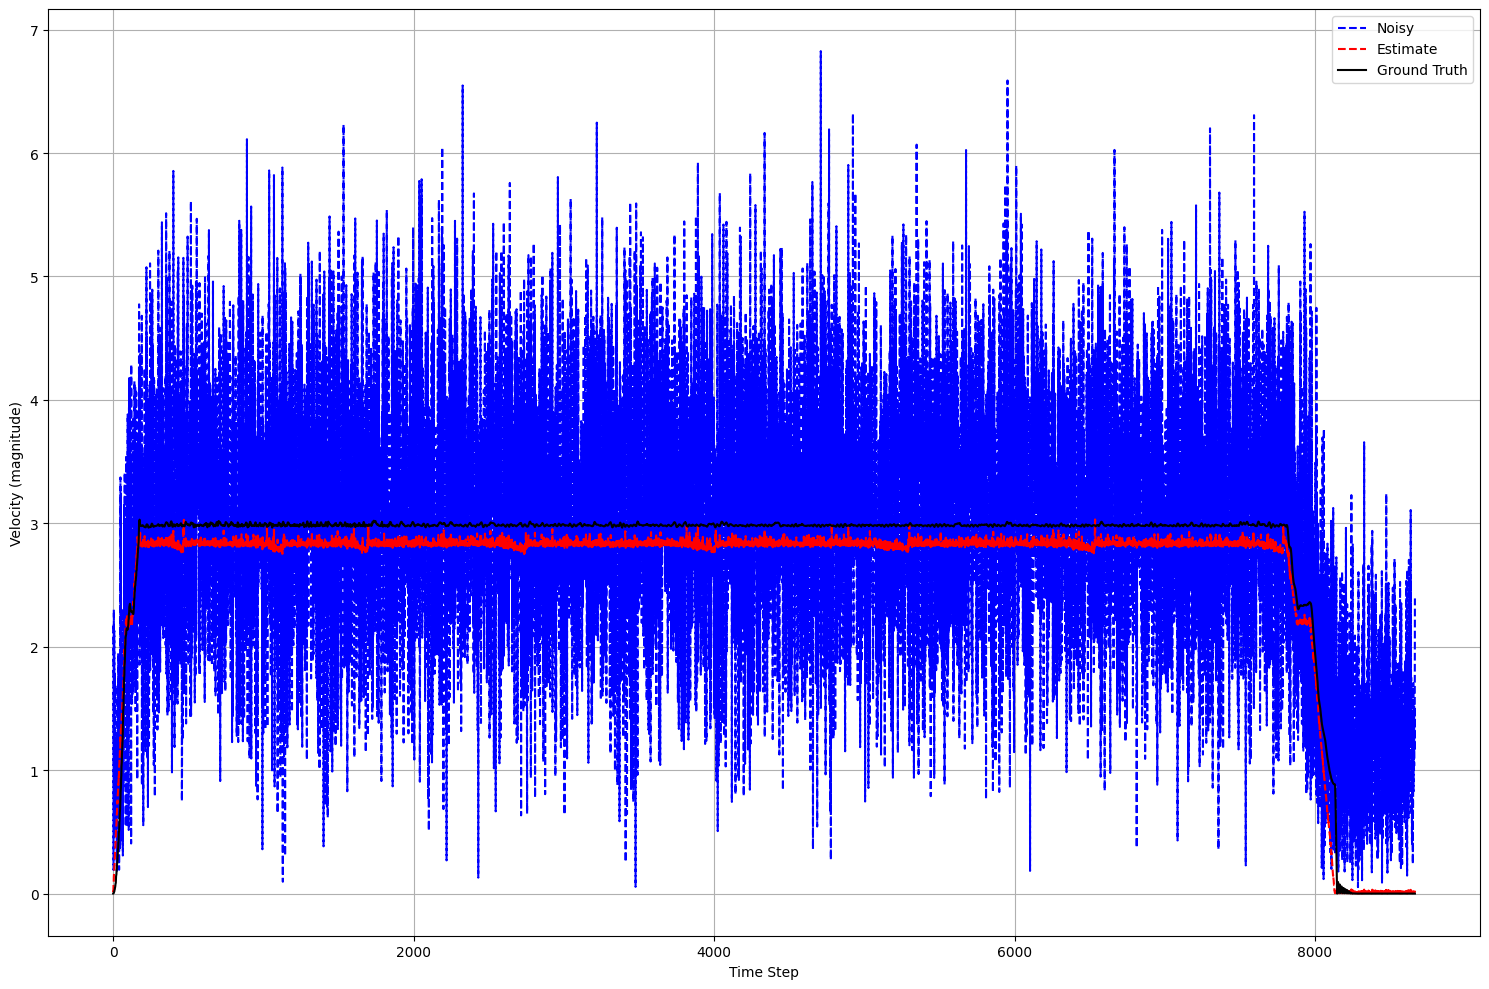

In [161]:
'''Checking Velocity Magnitudes'''
velocity_estimated = np.hypot(estimated_velocity[0].values, estimated_velocity[1].values)
velocity_actual = np.hypot(ground_truth_velocity[0].values, ground_truth_velocity[1].values)
velocity_noisy = np.hypot(noisy_velocity[0].values, noisy_velocity[1].values)

fig3, axes4 = plt.subplots(1, 1, figsize=(15, 10))
axes4.plot(range(len(velocity_noisy)),velocity_noisy, label='Noisy', color='blue', linestyle='--')
axes4.plot(range(len(velocity_estimated)),velocity_estimated, label='Estimate', color='red', linestyle='--')
axes4.plot(range(len(velocity_actual)),velocity_actual, label='Ground Truth', color='black')
axes4.set_ylabel('Velocity (magnitude)')
axes4.legend()
axes4.grid()
plt.xlabel("Time Step")
plt.tight_layout()  # Adjust spacing between subplots (optional)
plt.show()


In [164]:
'''Making sure that all arrays are of the same length'''
if len(ground_truth_position[0])<len(estimated_position[0]):
    min1 = len(ground_truth_position[0])
else:
    min1 = len(estimated_position[0])

if len(ground_truth_velocity[0])<len(estimated_velocity[0]):
    min2 = len(ground_truth_velocity[0])
else:
    min2 = len(estimated_velocity[0])

if len(ground_truth_heading)<len(estimated_heading):
    min3 = len(ground_truth_heading)
else:
    min3 = len(estimated_heading)
    
'''Performing some error analytics'''

max_X_position_error = np.max(ground_truth_position[0][:min1] - estimated_position[0][:min1])
max_Y_position_error = np.max(ground_truth_position[1][:min1] - estimated_position[1][:min1])
max_Z_position_error = np.max(ground_truth_position[2][:min1] - estimated_position[2][:min1])

MSE_X_position = np.mean((ground_truth_position[0][:min1] - estimated_position[0][:min1])**2)
MSE_Y_position = np.mean((ground_truth_position[1][:min1] - estimated_position[1][:min1])**2)
MSE_Z_position = np.mean((ground_truth_position[2][:min1] - estimated_position[2][:min1])**2)

max_X_velocity_error = np.max(ground_truth_velocity[0][:min2] - estimated_velocity[0][:min2])
max_Y_velocity_error = np.max(ground_truth_velocity[1][:min2] - estimated_velocity[1][:min2])
max_Z_velocity_error = np.max(ground_truth_velocity[2][:min2] - estimated_velocity[2][:min2])

MSE_X_velocity = np.mean((ground_truth_velocity[0][:min2] - estimated_velocity[0][:min2])**2)
MSE_Y_velocity = np.mean((ground_truth_velocity[1][:min2] - estimated_velocity[1][:min2])**2)
MSE_Z_velocity = np.mean((ground_truth_velocity[2][:min2] - estimated_velocity[2][:min2])**2)

max_heading_error = ground_truth_heading[:min3] - estimated_heading[:min3]
index = np.where(max_heading_error == np.max(max_heading_error))
max_heading_error = np.abs(np.abs(estimated_heading[index[0][0]]) - ground_truth_heading[index[0][0]])
# max_heading_error = np.max(ground_truth_heading[:min3] - estimated_heading[:min3])
MSE_heading = np.mean((ground_truth_heading[:min3] - estimated_heading[:min3])**2)


print("max_X_position_error: ", max_X_position_error)
print("MSE_X_position: ", MSE_X_position)
print("")
print("max_Y_position_error: ", max_Y_position_error)
print("MSE_Y_position: ", MSE_Y_position)
print("")
print("max_Z_position_error: ", max_Z_position_error)
print("MSE_Z_position: ", MSE_Z_position)
print("")
print("max_X_velocity_error: ", max_X_velocity_error)
print("MSE_X_velocity: ", MSE_X_velocity)
print("")
print("max_Y_velocity_error: ", max_Y_velocity_error)
print("MSE_Y_velocity: ", MSE_Y_velocity)
print("")
print("max_Z_velocity_error: ", max_Z_velocity_error)
print("MSE_Z_velocity: ", MSE_Z_velocity)
print("")
print("max_heading_error: ", max_heading_error)
print("MSE_heading: ", MSE_heading)


max_X_position_error:  1.0415078741214776
MSE_X_position:  0.09983915994978375

max_Y_position_error:  0.8359112357178389
MSE_Y_position:  0.05554384320779083

max_Z_position_error:  0.8685632521419643
MSE_Z_position:  0.05420745855122433

max_X_velocity_error:  1.3395459791851143
MSE_X_velocity:  2.309675240945477

max_Y_velocity_error:  0.9605252194955903
MSE_Y_velocity:  0.4260804653694167

max_Z_velocity_error:  0.0366012562097113
MSE_Z_velocity:  0.0001015585326075122

max_heading_error:  6.414380490629545
MSE_heading:  2.8266116912564336


In [163]:
max_heading_error = ground_truth_heading[:min3] - estimated_heading[:min3]
index = np.where(max_heading_error == np.max(max_heading_error))
print(np.rad2deg(ground_truth_heading[index[0][0]]))
print(np.rad2deg(estimated_heading[index[0][0]]))
print(index[0][0])
np.abs(np.abs(estimated_heading[index[0][0]])-ground_truth_heading[index[0][0]])

179.76027916204836
-187.75665114207888
6362


0.13956301926575065